# Machine learning III

files needed = ('Hitters.csv')

This book continues our foray into machine learning. Our goals here are modest. We would like to
1. learn a bit about how machine learning is similar to, and different from, econometrics.  
2. introduce the scikit-learn package which is chock full of 'machine learning' tools. 
3. work on some *validation* methods, which are an important part of the machine learning toolkit. 
4. explore the ridge and lasso regression models

In this notebook, we study the ridge and lasso regressions. These are methods that put discipline on the importance of the independent variables of the regression.

This notebook is loosely based on Chapter 6 from *An Introduction to Statistical Learning* by James, Witten, Hastie, and Tibshirani. This is an easy to follow introduction that is light on the mathematics behind the methods.

## Econometrics v. Statistical learning
This is overly broad and general, but hopefully helpful. Consider the model

$$ y = f(X) + \epsilon.$$

### Econometrics
Econometrics is mainly concerned with *inference*. By this, we mean that the goal is to understand the structure of $f(\;)$. Econometricians are concerned about the 'true' value of the components of $f(\;)$. We worry a lot about endogeneity, omitted variables, and whether the properties of $f(\;)$ are consistent with the theory.  Practically, 

1. The $X$ variables included in the model are guided by theory.
2. The focus is on in-sample fit. How well does the model fit the data?

### Statistical (machine) learning
Statistical learning is mainly concerned with *prediction*. By this, we mean the ability of the model to predict the values of $y$, given $X$, for data that are not used to estimate (or, in machine learning-ese, train) the model of $f(\;)$. The guiding principle here is the *bias-variance tradeoff*. \[more on this in a minute\]. Practically, 

1. The $X$ variables included in the model are guided by the mean-variance tradeoff. 
2. The focus is on out-of-sample fit. How well does the model predict data not used to estimate the model?

\[The bias-variance tradeoff exist in econometrics, too. Theory typically disciplines our definition of $X$.



### Evaluating model predictions

The fundamental constraint in machine learning is the *bias-variance tradeoff*. Roughly speaking, there is no free lunch. 

Let's start with an example. Suppose we wanted to predict the number of people on the union terrace on a Friday. For 5 Fridays, we send out a team to count the number of people on the terrace (the $y$ variable). We also record the temperature, the price of beer, if it is a home football weekend, the value of the stock market, the number of sailboats on Mendota, and the euro-dollar exchange rate (the $X$ variables).  

We use the data to estimate our model $y=f(X)+\epsilon$ and use the $X$ data for a 6th Friday to predict the number of people on the terrace, $\hat{y}$. We then evaluate our estimate by comparing our prediction to the actual number of people on the terrace on the 6th Friday, $(y - \hat{y})^2$. This is a measure of how well our model works at predicting **out of sample**. 

Now, suppose we repeat this experiment $M$ times. We collect $M$ data sets, estimate the model $M$ times, predict the 6th Friday $M$ times. We can form the expected test mse as

$$\frac{1}{M}\sum_{m=1}^M(y_m-\hat{y}_m)^2$$

It is straightforward to show that this expression can be decomposed into 

$$\begin{align*}
\frac{1}{M}\sum_{m=1}^M(y_m-\hat{y}_m)^2 & = \left(E\left[\,\hat{f}(X)\right]-f(X) \right)^2 + E\,\left(\,\hat{f}(X)-E\left[\,\hat{f}(X)\right]\right)^2 + \text{var}(\epsilon)\\
                                         &= \text{bias}^2 + \text{variance} + \text{var}(\epsilon).\\
\end{align*}$$

Note that all three terms are positive. We can't do anything about the third term, it is the *irreducible* error. The other two terms we would like to make as small as possible. Unfortunately, shrinking one of the two terms tends to increase the other term. 

### Bias and variance
The **bias term** tells us, on average, how close we get to the true model. Are we systematically over- or under-predicting $y$?

The **variance term** tells us how much our estimates vary as we use different training datasets to estimate the model.

Quick check: Think about shooting arrows at a target. What does a low-variance high-bias attempt look like? A low-bias low-variance look like?

### The bias-variance tradeoff

We would like to minimize the bias and the variance of the test mse. How can we do so? 

In the linear models we are considering, complexity increases as we add more variables to $X$. This includes adding polynomials of our independent variables, interactions, etc. How does complexity influence the testing error?  

* As we **increase the complexity** of our model $f(\;)$ the **squared bias tends to decrease**. 

* As we **increase the complexity** of our model $f(\;)$ the **variance tends to increase**.

This is the tradeoff. As we add features to the model, the bias decreases, but the variance increases. This gives rise to a u-shaped mse. This [figure](http://www-bcf.usc.edu/~gareth/ISL/Chapter2/2.12.pdf) from James et al. is a good illustration. 

### Overfitting

Behind the bias-variance tradoff is the idea of overfitting. The more complex the model, the more it will capture variation in $y$ due to the random error ($\epsilon$). 

* This makes the model fit the data better (lower bias). We are capturing $y$ behavior from both $f(\;)$ and $\epsilon$.
* This makes the model more variable. A new set of training data will have different $\epsilon$'s. The estimate will change to match these new values of $\epsilon$. Since $\epsilon$ is not related to $f(\;)$, we are making the estimate noisier.

## Shrinkage methods
The bias-variance tradeoff says that we want to constrain our model's complexity. There are many, many, many ways to go about this. For linear models, two common and easy to grasp methods are the ridge and the lasso regression. 

Let's see how they work. 

In [1]:
import pandas as pd                 # data handling
import numpy as np                  # numerical methods
import matplotlib.pyplot as plt     # plots

Load data on baseball players. Each row is a player. The variable we would like to predict is salary.

In [2]:
base = pd.read_csv('Hitters.csv')
print(base.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 21 columns):
Unnamed: 0    322 non-null object
AtBat         322 non-null int64
Hits          322 non-null int64
HmRun         322 non-null int64
Runs          322 non-null int64
RBI           322 non-null int64
Walks         322 non-null int64
Years         322 non-null int64
CAtBat        322 non-null int64
CHits         322 non-null int64
CHmRun        322 non-null int64
CRuns         322 non-null int64
CRBI          322 non-null int64
CWalks        322 non-null int64
League        322 non-null object
Division      322 non-null object
PutOuts       322 non-null int64
Assists       322 non-null int64
Errors        322 non-null int64
Salary        263 non-null float64
NewLeague     322 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 52.9+ KB
None


In [3]:
base.head(2)

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N


The data look okay, but we only have salary for 263 observations. Let's drop them. 

In [4]:
base = base.dropna()
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


### OLS

Let's start with ols to get a feel for things. Start by loading some packages.

In [5]:
from sklearn import linear_model                          # ols, ridge, lasso, 
from sklearn.preprocessing import StandardScaler          # normalize variables to have mu=0, std=1

Let's choose some variables that are potentially useful for predicting salary. We are purposely making this set large. The goal is determine how to constrain our choices. 

The ridge regression works best if the $X$ variables are on the same scale. The `StandardScaler()` normalizes the variables.

In [6]:
var_list = ['Hits', 'RBI', 'HmRun', 'Walks', 'Errors', 'Years', 'Assists', 'AtBat', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CWalks']

# Standardize the X vars so they have mean = 0 and std = 1
X = StandardScaler().fit_transform(base[var_list])

/Users/travis/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/travis/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Estimate the OLS regression. Don't worry about the l2 norm stuff yet. 

In [8]:
res_ols = linear_model.LinearRegression().fit(X, base['Salary'])
coef_norm_ols = np.linalg.norm(res_ols.coef_, ord=2)

print(res_ols.coef_)
print('The l2 norm of the ols coefficients is {0:5.1f}.'.format(coef_norm_ols))

[ 342.86853172   56.76095882   31.72386749  150.31756567  -10.80513874
  -28.76438817   25.9039893  -299.7189859   -95.89253928 -346.33866351
  257.07761972  448.22175687 -157.44988341]
The l2 norm of the ols coefficients is 810.4.


## The ridge regression

The ridge regression chooses $\beta$ to minimize the residual sum of squares plus a penalty function 

$$
\begin{align*}
=& \text{RSS}+ \alpha \left(\sum_{j=1}^p \beta_j^2\right)^{0.5}\\
=&\sum_{i=1}^n(y_i-\hat{y}_i)^2 + \alpha \left(\sum_{j=1}^p \beta_j^2\right)^{0.5}
\end{align*}
$$

OLS minimizes RSS, so if $\alpha=0$ ridge collapses to OLS. We call $\alpha$ the tuning parameter. When $\alpha>0$, models are penalized for how large their coefficients are. The term multiplying $\alpha$ is the l2 norm of the coefficient vector.  

The `Ridge()` function is part of `linear_models` in scikit-learn [(docs)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). 

First, let's estimate the model with $\alpha=0$. This should return the ols estimate. 

In [9]:
res_ridge_0 = linear_model.Ridge(alpha = 0.0).fit(X, base['Salary'])
coef_norm_r0 = np.linalg.norm(res_ridge_0.coef_, ord=2)

print(res_ridge_0.coef_)
print('The l2 norm of the ridge(a=0) coefficients is {0:5.1f}.'.format(coef_norm_r0))

[ 342.86853172   56.76095882   31.72386749  150.31756567  -10.80513874
  -28.76438817   25.9039893  -299.7189859   -95.89253928 -346.33866351
  257.07761972  448.22175687 -157.44988341]
The l2 norm of the ridge(a=0) coefficients is 810.4.


Now estimate the ridge model with $\alpha=100$. This adds a penalty to each coefficient that is not zero. 

In [10]:
res_ridge_100 = linear_model.Ridge(alpha = 100.0).fit(X, base['Salary'])
coef_norm_r100 = np.linalg.norm(res_ridge_100.coef_, ord=2)

print(res_ridge_100.coef_)
print('The l2 norm of the ridge(a=100) coefficients is {0:5.1f}.'.format(coef_norm_r100))

[ 52.15138012  38.4847365    8.50483461  50.13721432 -11.04140017
   5.05574661  -2.28073256   2.33576236  26.24338138  38.80799151
  59.32436779  59.90473347  20.04176666]
The l2 norm of the ridge(a=100) coefficients is 129.0.


That decreased the norm of the coefficients quite a bit. We can keep going... 

In [11]:
res_ridge_800 = linear_model.Ridge(alpha = 800.0).fit(X, base['Salary'])
coef_norm_r800 = np.linalg.norm(res_ridge_800.coef_, ord=2)

print(res_ridge_800.coef_)
print('The l2 norm of the ridge(a=800) coefficients is {0:5.1f}.'.format(coef_norm_r800))


[24.26292247 22.88938261 14.84319012 25.27605131 -2.84991212 17.94244586
 -0.10430381 17.54807161 21.14484914 27.12005935 30.11332925 30.81759733
 23.94825642]
The l2 norm of the ridge(a=800) coefficients is  78.9.


In [14]:
pd.DataFrame({'var': var_list, 
              'ols': res_ols.coef_ , 'ridge 100':res_ridge_100.coef_, 'ridge 800':res_ridge_800.coef_ })

,var,ols,ridge 100,ridge 800
0,Hits,342.868532,52.151380,24.262922
1,RBI,56.760959,38.484737,22.889383
2,HmRun,31.723867,8.504835,14.843190
3,Walks,150.317566,50.137214,25.276051
4,Errors,-10.805139,-11.041400,-2.849912
5,Years,-28.764388,5.055747,17.942446
6,Assists,25.903989,-2.280733,-0.104304
7,AtBat,-299.718986,2.335762,17.548072
8,Runs,-95.892539,26.243381,21.144849
9,CAtBat,-346.338664,38.807992,27.120059


### What size penalty? 

We see that increasing $\alpha$ decreases the norm of the coefficients. How big should $\alpha$ be? We want the $\alpha$ that gives us the best test mse. As we discussed last week, cross-validation methods allow us to evaluate test mses.

The scikit package has a method that combines the ridge estimation with cross validation. It is called `RidgeCV()` [(docs)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

We pass to `RidgeCV()` a list of the alpha values to try. 

In [15]:
alpha_grid = [1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]

# Setting 'store_cv_values' to true will hang on to all the test mses from the CV. Otherwise, it only keep the best one.
model = linear_model.RidgeCV(alphas=alpha_grid, store_cv_values = True).fit(X,base['Salary'])

The function returns an object with useful attributes and methods. Let's look at a few.

In [16]:
# The .alpha_ holds the best alpha
print('The best alpha from the candidate alphas is {0}.'.format(model.alpha_))

The best alpha from the candidate alphas is 1.0.


In [17]:
best_coef_ridge = pd.DataFrame({'var':var_list, 'coef': model.coef_}) 
print(best_coef_ridge)

        var        coef
0      Hits  309.382723
1       RBI   61.508414
2     HmRun   21.763078
3     Walks  140.610067
4    Errors  -12.050349
5     Years  -47.933631
6   Assists   19.984472
7     AtBat -277.165125
8      Runs  -70.493630
9    CAtBat -173.607372
10    CHits  177.955937
11    CRuns  355.839427
12   CWalks -139.569671


In [18]:
# Since I set 'store_cv_values' to true, I have the matrix of all the test mse. Columns correspond to alpha values, 
# and there is one row for each observation, since the function uses loocv

print(model.cv_values_)
print(model.cv_values_.shape)

[[3.02843609e+04 3.01781068e+04 2.91875911e+04 ... 2.44419200e+00
  1.35781601e+03 3.14392936e+03]
 [4.90961822e+04 4.90869411e+04 4.89995087e+04 ... 1.81722250e+04
  9.46378842e+03 4.23064769e+03]
 [3.58334242e+05 3.58009759e+05 3.54643288e+05 ... 1.34723883e+05
  5.49162558e+04 6.19574577e+03]
 ...
 [3.57189181e+03 3.58819796e+03 3.73565465e+03 ... 1.18305515e+04
  1.32823134e+04 2.04707709e+04]
 [8.11076387e+04 8.10128280e+04 8.01251664e+04 ... 4.62882943e+04
  8.80650163e+04 1.58284001e+05]
 [2.87812484e+04 2.89069399e+04 3.01449649e+04 ... 4.67532198e+04
  9.66306892e+04 1.87097272e+05]]
(263, 7)


In [19]:
# The mean test mse for each value of alpha
model.cv_values_.mean(axis=0)

array([124401.99686713, 124327.02083352, 123702.9384668 , 121624.58267113,
       125267.96774173, 136848.44181746, 184530.51723419])

## The lasso regression
The lasso regression works like the ridge, but with a different penalty function. 

$$
\begin{align*}
=& \text{RSS}+ \alpha \sum_{j=1}^p | \beta_j|\\
=&\sum_{i=1}^n(y_i-\hat{y}_i)^2 + \alpha \sum_{j=1}^p | \beta_j|
\end{align*}
$$

The penalty function here is the l1 norm, or the sum of the absolute values of the absolute values of the coefficient. The major difference between the ridge and the lasso is that the lasso can generate coefficients that are zero, dropping them from the model and making it simpler.

The `Lasso` regression is part of `linear_models` in scikit-learn [(docs)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).   

In [20]:
res_lasso_0 = linear_model.Lasso(alpha = 0.0).fit(X, base['Salary'])
coef_norm_l0 = np.linalg.norm(res_lasso_0.coef_, ord=1)

print(res_lasso_0.coef_)
print('The l2 norm of the lasso(a=0) coefficients is {0:5.1f}.'.format(coef_norm_l0))

[ 342.89783759   56.76284806   31.72132886  150.32357815  -10.80369482
  -28.78042787   25.90056085 -299.74466361  -95.90077659 -346.15890107
  256.90508626  448.24973975 -157.47305179]
The l2 norm of the lasso(a=0) coefficients is 2251.6.


/Users/travis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """Entry point for launching an IPython kernel.
/Users/travis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/travis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [21]:
res_lasso_2 = linear_model.Lasso(alpha = 2.0).fit(X, base['Salary'])
coef_norm_2 = np.linalg.norm(res_lasso_2.coef_, ord=1)

lassos = pd.DataFrame({'var':var_list, 'lasso 2': res_lasso_2.coef_}) 
print(lassos)
print('\nThe l1 norm of the lasso(a=2) coefficients is {0:5.1f}.'.format(coef_norm_2))

        var     lasso 2
0      Hits  289.542400
1       RBI   68.101418
2     HmRun    2.138459
3     Walks  123.811873
4    Errors   -3.454889
5     Years  -47.045848
6   Assists    4.797088
7     AtBat -260.218269
8      Runs  -41.705288
9    CAtBat   -0.000000
10    CHits   10.262085
11    CRuns  336.280067
12   CWalks -123.029009

The l1 norm of the lasso(a=2) coefficients is 1310.4.


## Practice
Take a few minutes and try the following. Feel free to chat with those around if you get stuck. The TA and I are here, too.

1. Try estimating a lasso regression when $\alpha = 5$. Compare the coefficient vector to the lasso with $\alpha=2$ from above.

In [23]:
res_lasso_5 = linear_model.Lasso(alpha = 5.0).fit(X, base['Salary'])
coef_norm_5 = np.linalg.norm(res_lasso_5.coef_, ord=1)

lassos = pd.DataFrame({'var':var_list, 'lasso 2':res_lasso_2.coef_, "lasso 5":res_lasso_5.coef_})
lassos

,var,lasso 2,lasso 5
0,Hits,289.542400,187.192908
1,RBI,68.101418,53.895913
2,HmRun,2.138459,0.000000
3,Walks,123.811873,84.479341
4,Errors,-3.454889,-4.387499
5,Years,-47.045848,-25.720740
6,Assists,4.797088,-0.000000
7,AtBat,-260.218269,-144.987736
8,Runs,-41.705288,-0.000000
9,CAtBat,-0.000000,-0.000000


2. Estimate lasso regressions with $\alpha$ equal to 10 and 200. What is happening to the coefficients? What is happening to the norm of the coefficients? Does this make sense? 

In [26]:
res_lasso_10 = linear_model.Lasso(alpha = 10.0).fit(X, base['Salary'])
coef_norm_10 = np.linalg.norm(res_lasso_10.coef_, ord=1)

res_lasso_200 = linear_model.Lasso(alpha = 200.0).fit(X, base['Salary'])
coef_norm_200 = np.linalg.norm(res_lasso_200.coef_, ord=1)

lassos = pd.DataFrame({'var':var_list, 'lasso 2':res_lasso_2.coef_, "lasso 5":res_lasso_5.coef_, 
                       "lasso 10":res_lasso_10.coef_, "lasso 200":res_lasso_200.coef_})
print(lassos)
a = [2, 5, 10, 200]
coef_norm = [coef_norm_2, coef_norm_5, coef_norm_10, coef_norm_200]
i = 0
for var in a: 
    print("\nThe norm of the lasso(a={})".format(var), "coefficients is {0:4.1f}".format(coef_norm[i]))
    i = i + 1

        var     lasso 2     lasso 5    lasso 10  lasso 200
0      Hits  289.542400  187.192908   75.623355   0.000000
1       RBI   68.101418   53.895913   39.965107   0.000000
2     HmRun    2.138459    0.000000    0.000000   0.000000
3     Walks  123.811873   84.479341   62.899989   0.000000
4    Errors   -3.454889   -4.387499   -8.154722   0.000000
5     Years  -47.045848  -25.720740   -0.000000   0.000000
6   Assists    4.797088   -0.000000   -0.000000   0.000000
7     AtBat -260.218269 -144.987736   -0.000000   0.000000
8      Runs  -41.705288   -0.000000    0.000000   0.000000
9    CAtBat   -0.000000   -0.000000    0.000000   0.000000
10    CHits   10.262085   66.157744   56.927126   0.000000
11    CRuns  336.280067  180.220618  135.248380  53.351392
12   CWalks -123.029009  -32.203122   -0.000000   0.000000

The norm of the lasso(a=2) coefficients is 1310.4

The norm of the lasso(a=5) coefficients is 779.2

The norm of the lasso(a=10) coefficients is 378.8

The norm of the lasso

3. Use the `LassoCV()` function [(docs)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) to estimate lasso regressions for the following grid of alphas:
```python
alpha_grid = [1, 1.5, 2, 3, 4, 5, 6, 8, 10]
```
Set the `cv` parameter to 10. This means the method will use k-fold cross validation with k=10.

In [27]:
alpha_grid = [1, 1.5, 2, 3, 4, 5, 6, 8, 10]

LassoModel = linear_model.LassoCV(alphas=alpha_grid, cv=10).fit(X, base.Salary)

4. Which $\alpha$ worked best? 
5. Use the `.mse_path_` attribute of the object returned by `LassoCV()` to return a (9,10) sized array. The 9 corresponds to the number of alphas and the 10 corresponds to the test mses from the 10-fold cross validation the function is using. 

In [30]:
print('The best alpha from the candidate alphas for Lasso regression is {0}.'.format(LassoModel.alpha_))

print(LassoModel.mse_path_)

print(LassoModel.mse_path_.shape)

The best alpha from the candidate alphas for Lasso regression is 2.0.
[[ 59715.45367525  40325.34629318 248441.91775733 102133.40225221
  135626.58114878  91300.43734036 290687.83887259 114133.23332923
   75302.6025012  111842.68754428]
 [ 62267.10326526  40614.58420742 246838.92085146 100362.85290138
  133602.83519904  90579.28724818 292537.70413761 118046.56171965
   76584.49546511 111928.76197747]
 [ 67553.82290672  41537.28766873 240442.49097707  96252.73211127
  131157.54015128  90802.56340968 289330.92141273 122781.23550956
   81206.42903536 106662.7529034 ]
 [ 70495.39299391  41858.73905725 236679.13919188  92603.36939772
  128543.52970488  91294.18805385 285868.64189977 125913.78872457
   83177.63932055 101999.64271963]
 [ 73848.52629952  41151.75163075 230450.94620454  90531.23594616
  126024.39306217  92180.97774063 282279.51051266 130457.8941669
   84956.6190894   97712.14570727]
 [ 77864.94959285  40572.59262406 223585.51442406  89141.05713518
  124045.91149555  93633.53989

6. Create a plot with $\alpha$ on the x-axis and the average test mse on the y-axis. To make sure the mse correspond to the correct alpha, use the `.alphas_` attribute of the results object for the x values. 

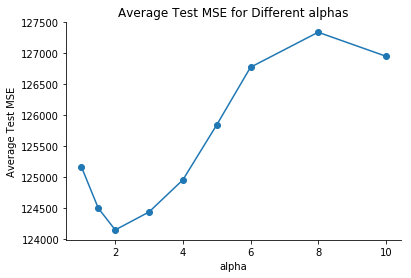

In [44]:
fig, ax = plt.subplots()

ax.plot(LassoModel.alphas_, LassoModel.mse_path_.mean(axis=1), marker="o")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Average Test MSE for Different alphas")
ax.set_xlabel("alpha")
ax.set_ylabel("Average Test MSE")

plt.show()

7. Now let the computer sort out the best tuning parameter. Call `LassoCV()` as before, but do not use the 'alphas' argument. The algorithm will search for the best $\alpha$.  

What is the optimal $\alpha$? 

What $\alpha$'s did the algorithm try? \[Use the `.alphas_` attribute.\]

In [39]:
LassoModel_comp = linear_model.LassoCV(cv=10).fit(X, base.Salary)

print('The best alpha from the candidate alphas for Lasso regression is {0}.'.format(LassoModel_comp.alpha_))

print("The algorithm tried the following alphas:\n", LassoModel_comp.alphas_)

The best alpha from the candidate alphas for Lasso regression is 2.0550112515416843.
The algorithm tried the following alphas:
 [2.53351392e+02 2.36276356e+02 2.20352121e+02 2.05501125e+02
 1.91651037e+02 1.78734399e+02 1.66688298e+02 1.55454065e+02
 1.44976981e+02 1.35206018e+02 1.26093585e+02 1.17595299e+02
 1.09669770e+02 1.02278394e+02 9.53851728e+01 8.89565314e+01
 8.29611589e+01 7.73698544e+01 7.21553852e+01 6.72923537e+01
 6.27570743e+01 5.85274575e+01 5.45829028e+01 5.09041978e+01
 4.74734253e+01 4.42738753e+01 4.12899643e+01 3.85071589e+01
 3.59119052e+01 3.34915630e+01 3.12343438e+01 2.91292535e+01
 2.71660393e+01 2.53351392e+01 2.36276356e+01 2.20352121e+01
 2.05501125e+01 1.91651037e+01 1.78734399e+01 1.66688298e+01
 1.55454065e+01 1.44976981e+01 1.35206018e+01 1.26093585e+01
 1.17595299e+01 1.09669770e+01 1.02278394e+01 9.53851728e+00
 8.89565314e+00 8.29611589e+00 7.73698544e+00 7.21553852e+00
 6.72923537e+00 6.27570743e+00 5.85274575e+00 5.45829028e+00
 5.09041978e+00 4.

8. Using the `mse_path_` and `alphas_` attributes, create a plot with $\alpha$ on the x-axis and the average test mse on the y-axis.

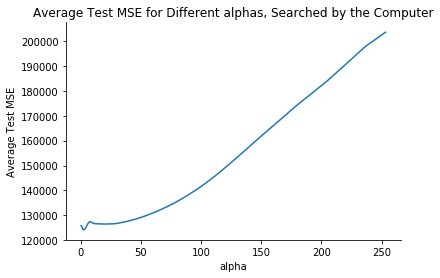

In [46]:
fig, ax = plt.subplots()

ax.plot(LassoModel_comp.alphas_, LassoModel_comp.mse_path_.mean(axis=1))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Average Test MSE for Different alphas, Searched by the Computer")
ax.set_xlabel("alpha")
ax.set_ylabel("Average Test MSE")

plt.show()

9. Display the optimal coefficient vector. Did the lasso eliminate any variables? 

In [43]:
lasso_comp = pd.DataFrame({"var":var_list, "lasso_coef":LassoModel_comp.coef_})
print(lasso_comp)

print("The Lasso regression eliminated variable 'CAtBat'")

        var  lasso_coef
0      Hits  286.786874
1       RBI   68.325339
2     HmRun    1.474243
3     Walks  122.818539
4    Errors   -3.312956
5     Years  -46.653438
6   Assists    4.403061
7     AtBat -257.913655
8      Runs  -39.978953
9    CAtBat   -0.000000
10    CHits   11.966717
11    CRuns  332.473667
12   CWalks -121.022429
The Lasso regression eliminated variable 'CAtBat'
